# Covid-19 Timeseries Forecasting

The aim of this notebook is to identify the optimal model from a given simple
parametric family that best characterizes the growth curve of COVID-19 cases without 
overfitting the data.  
The first part of the dataset (up to 20 March) will be used for training, along [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for selecting the degree of our polynomial.  
The chosen model will be tested on the rest of the dataset.  
  
Intuitively is a timeseries forecasting model able to accurately predict the future number of cases?  
I believe that it is not for most countries. There are many factors that a time series model will not be able to forecast. A country may decide to take some measures like lockdowns, increase the number of tests, promote self isolation, etc.
  
  
>This is most obvious with weather forecasting where we have excellent models based on the physics of the atmosphere. No time series model will perform as well as a good atmospheric model for forecasting short-term weather. That’s why meteorologists don’t use time series models [(ref)](https://robjhyndman.com/hyndsight/forecasting-covid19/).  
  
However, it is an interesting exercise on the field of forecasting in a domain that is highly interpretable (at least at the depths I am reaching).


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime
import logging

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA

## Data gathering

As in the [previous notebook](https://github.com/MikeXydas/Weekend-EDAs/blob/master/Covid19_Testing_Importance.ipynb) the number of confirmed cases will be taken from the [John Hopkins](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) dataset which is daily updated.  
We will group by country name and sum over provinces/states so as to have the cases per country.

In [16]:
# In case the link fails I am including a stored dataset which is not the most up to date
try:
    confirmed_cases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
                                     index_col=['Country/Region'])
    
    # Drop unused columns Lat, Long
    confirmed_cases_df = confirmed_cases_df.drop('Lat', axis=1)
    confirmed_cases_df = confirmed_cases_df.drop('Long', axis=1)

    # Group by and sum number of cases of each country
    confirmed_cases_df = confirmed_cases_df.groupby(['Country/Region']).sum()

    # Filter the countries that had no cases up until 20/3/2020 to avoid divisions by zero
    confirmed_cases_df = confirmed_cases_df[confirmed_cases_df['3/20/20'] != 0]
except:
    logging.warning("GitHub link not working. Using stored csv file")
    confirmed_cases_df = pd.read_csv(filepath_or_buffer="datasets/covid_19_country_cases.csv")




display(confirmed_cases_df)

# confirmed_cases_df.to_csv(path_or_buf="datasets/covid_19_country_cases.csv")

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
Albania,0,0,0,0,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
Algeria,0,0,0,0,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
Andorra,0,0,0,0,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
Angola,0,0,0,0,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,0,0,0,0,0,0,0,0,0,...,42,42,70,70,77,84,91,107,107,119
Vietnam,0,2,2,2,2,2,2,2,2,2,...,85,91,94,113,123,134,141,153,163,174
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,44,47,48,52,59,59,59,84,91,98


We will try to forecast the global number of cases so we can sum the rows. However, we keep the `confirmed_cases_df` DataFrame in case we need it for comparisons.

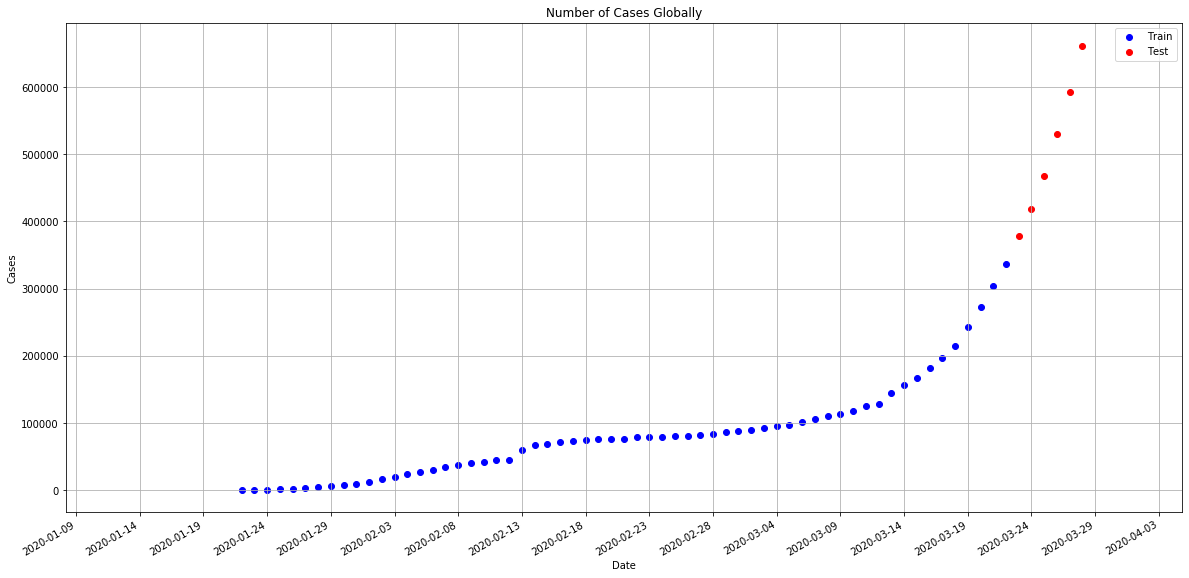

In [17]:
global_cases_df = confirmed_cases_df.sum()    # Sum over all countries to get global number of cases for each day

# Plot the number of cases for each day globally
x_values = [datetime.datetime.strptime(d[:-2]+ '20' + d[-2:],"%m/%d/%Y").date() for d in global_cases_df.index]
y_values = global_cases_df.values

fig, ax = plt.subplots(figsize=(20, 10))
ax = plt.gca()
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=5)    # Add an interval on the x-axis so as to not be cluttered
ax.xaxis.set_major_locator(locator)

# We will use the last 6 days as a test set
plt.scatter(x_values[:-6], y_values[:-6], color="blue", label="Train")
plt.scatter(x_values[-6:], y_values[-6:], color="red", label="Test")

ax.set_xlabel("Date")
ax.set_ylabel("Cases")
plt.title("Number of Cases Globally")
plt.legend()

plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

## Global Cases - Polynomial Regression

Firstly, we will create a model able to forecast future global number of future cases. This will help us have a greater understanding of a pipeline we could later create to train a model for each country separately.  
On the above plot we will use the blue part in order to find the degree of our polynomial and train our linear regression model, and the red part for testing.
### Training

In [18]:
x_series = np.arange(len(x_values))    # Transform dates to an integer mapping for easier parsing

# Split the data in training and testing and
# add a new axis so as the PolynomialFeatures input has the expected 2D shape
train_X = x_series[:-7, np.newaxis]
train_Y = y_values[:-7, np.newaxis]

test_X = x_series[-7:, np.newaxis]
test_Y = y_values[-7:, np.newaxis]

# Calculate the models up to 9th degree and cache them in a dictionary
models_dict = {}
for degree in range(1,10):
    # Create the new features
    # eg degree=2, [a] => [a^0, a^1, a^2]
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(train_X)

    # Train a linear regression model with our new polynmial feature set
    model = LinearRegression()
    model.fit(x_poly, train_Y)
    
    # Cache the model and the new set of features
    models_dict[degree] = [model, x_poly]

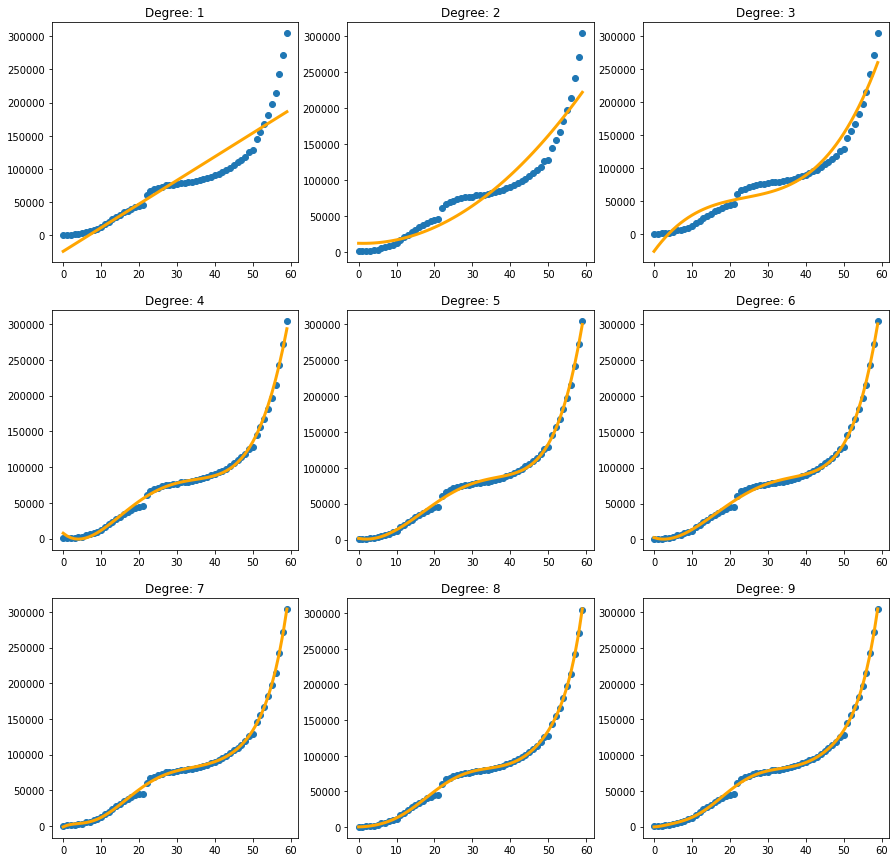

In [19]:
fig = plt.figure(figsize=(15, 15))
plot_index = 1

# We will create 9 plots one for each degree
for degree, model_features in models_dict.items():
    ax = fig.add_subplot(3, 3, plot_index)
    
    # Plot our true data
    plt.scatter(train_X, train_Y)
    
    # Use our new model to predict on our train set
    pred_train_Y = model_features[0].predict(model_features[1])    
    
    plt.plot(train_X, pred_train_Y, linewidth=3, label=f'Degree: {str(degree)}', color="orange")
    plot_index += 1
    
    plt.title(f"Degree: {degree}")
    
    
plt.show()

**Visually** we observe that the polynomial of the **4th degree** is the simplest model that seems to be good at capturing the shape of our data. To prove this with a more robust way we will use the **Bayesian Information Criterion (BCI)**.
  
### Metrics
**BCI**: Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models. It deals with overfitting since it **penalizes models that need many parameters**. So in our case as the degree of the polynomial increases the penalty will increase too.

$$BIC = kln(n) -2ln(\hat{L})$$
* $n$ is the number of data points (number of days used for training)
* $k$ is the number of free parameters (in our case degree + 1 due to intercept)
* $\hat{L}$ is the maximized value of the likelihood of our model

In order to calculate the $\hat{L}$ we first make some assumptions.  
Linear regression is in the form of $Y = Xβ + ε$ where $ε$ is the residue between the prediction and the true data result.  
Assuming that our residue $ε$ is **independent Gaussian noise** we can prove that the **maximum likelihood equals the mean squared error metric** [(ref)](https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf).
  
Under these assumptions we calculate BIC [(ref)](https://en.wikipedia.org/wiki/Bayesian_information_criterion#Gaussian_special_case):
$$BIC = nln(mse) + kln(n)$$

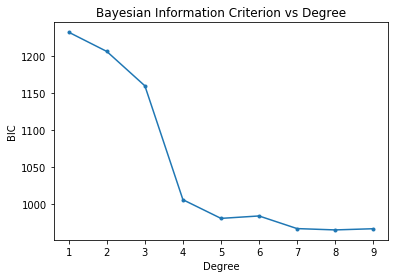

In [20]:
# Calculate MSE of Linear regression model
mse = mean_squared_error(train_Y, pred_train_Y)

# Calculate BIC for each model degree
bics = []
for degree, model_features in models_dict.items():
    # Use our new model to predict on our train set
    pred_train_Y = model_features[0].predict(model_features[1])

    mse = mean_squared_error(train_Y, pred_train_Y)
    n = len(train_Y)
    k = degree + 1    # We +1 for the intercept
    
    bics.append(n * np.log(mse) + k * np.log(n))


plt.plot(np.arange(1, len(bics) + 1), bics, marker=".")

plt.xlabel("Degree")
plt.ylabel("BIC")
plt.title("Bayesian Information Criterion vs Degree")

plt.show()

On the above plot we can see that the major on BIC happens from the 3rd to the 4th degree. However we need a rule in order to decide from the other models of degree 4 to 9.  
A usual criterion is [(ref)](https://en.wikipedia.org/wiki/Bayesian_information_criterion#Gaussian_special_case):  
  
Let $B^{\ast}$ be the lowest BIC value and $B$ a different BIC than $B^{\ast}$
* if $B - B^{\ast} < 2$, the difference is not important
* if $2 \leq B - B^{\ast} < 6$, the difference is positive
* if $6 \leq B - B^{\ast} \leq 10$, the difference is strong
* if $B - B^{\ast} > 10$, the difference is very strong

So we will deem as the best model **the one that has smallest degree and its BIC is not bigger than 2 from the model with the lowest BIC**.

In [21]:
def find_simplest_min_bic(bics, criterion=2):
    """Finds the smallest bic following the above rule"""
    true_min = np.argmin(bics)
    for which_bic in range(true_min):
        if bics[which_bic] - bics[true_min] < criterion:
            return which_bic    # Return the bic index that was the simplest model and B - B* < criterion(2)
    return true_min    # No B != B* with B - B* < criterion(2) found, return the index of the smallest bic 


bic_degree = find_simplest_min_bic(bics) + 1
print(f"Best BIC Degree: {bic_degree}")

Best BIC Degree: 7


We can see that the model that covers our criterion is the one of the **8th degree**. Following [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) we could relax our above criterion to a higher value and pick a more parsimonious model.

### Testing

Having found the degree of the polynomial that best fits our data without overfitting we must now forecast some dates that were not used in training (the last 7 days in our case) and evaluate our model's performance.  
  
In the cell below I compute the test set predictions along with the train set making it easier for me to plot them together.

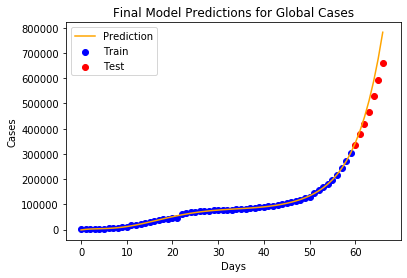

In [22]:
# Transform our train and test data to much the expected input degree of our chosen model
polyn_test_features = PolynomialFeatures(degree=bic_degree)
x_poly_train_test = polyn_test_features.fit_transform(np.vstack((train_X, test_X)))

# Predict on the train set and on the test set
chosen_model = models_dict[bic_degree]
pred_train_test_Y = chosen_model[0].predict(x_poly_train_test)

# Plot the predictions on the train and test set
plt.scatter(train_X, train_Y, color="blue", label="Train")
plt.scatter(test_X, test_Y, color="red", label="Test")
plt.plot(np.vstack((train_X, test_X)), pred_train_test_Y, color="orange", label="Prediction")
plt.xlabel("Days")
plt.ylabel("Cases")
plt.title("Final Model Predictions for Global Cases")
plt.legend()
plt.show()

We can see that the predicted line has a higher rate of increase than the actual rate. This can be expected since a lot of countries have taken measures (lockdowns and curfews) on the previous days and the results are showing up on our test dates. Consequently, our model is making pessimistic predictions.

## Country Cases Pipeline

On the first part of this notebook we predicted the global number of cases. This way we ended up having a simple problem that we can easily supervise its results and any mistake could be easily debugged. Using the above methods we will continue by creating a separate model for each country in the John Hopkins dataset.  
This pipeline will be used to forecast future (yet unknown) number of cases for each country which I am aiming to upload on [this Kaggle competition](https://www.kaggle.com/c/covid19-global-forecasting-week-2/data). 
  
Algorithm:  

```python
for country in countries:
    for degree in range(1, 10):  
        create_polynomial_features(degree)
        train_linear_regression_model()
    select_best_bic_model()
    save_best_model()
        
```

In [23]:
test_days = 6    # How many days will be used for testing
bic_criterion = 6
country_models = {}    # Dictionary where key:country_name, value:[LinearRegressionModel, degree]

x_data = np.arange(len(x_values))

# Iterate through the countries
for country, row in confirmed_cases_df.iterrows():
    train_X = np.array(x_data[:-test_days, np.newaxis])
    train_Y = np.array(row[:-test_days, np.newaxis])
    
    test_X = np.array(x_data[-test_days:, np.newaxis])
    test_Y = np.array(row[-test_days:, np.newaxis])
    
    models_list = []
    for degree in range(1, 10):
        # Creating polynomial features
        polynomial_features = PolynomialFeatures(degree=degree)
        x_poly = polynomial_features.fit_transform(train_X)

        # Train a linear regression model with our new polynmial feature set
        model = LinearRegression()
        model.fit(x_poly, train_Y)
        

        # Predict on the train set
        pred_train_Y = model.predict(x_poly)   
        
        # Calculate BIC value
        mse = mean_squared_error(train_Y, pred_train_Y)
        n = len(train_Y)
        k = degree + 1    # We +1 for the intercept
        bic = n * np.log(mse + 1e-2) + k * np.log(n)    # We do mse + 1e-2 to avoid log(0) 
        
        # Save the model and its bic
        models_list.append([model, bic])

    # Find the best BIC model 
    best_model = find_simplest_min_bic(np.array(models_list)[:, 1], criterion=bic_criterion)
    
    # Save the best model as the country model
    country_models[country] = [models_list[best_model][0], best_model + 1]    

Having created a forecasting model for each country we will then plot some example countries and see how good of a fit are our lines.

### Plots per Country

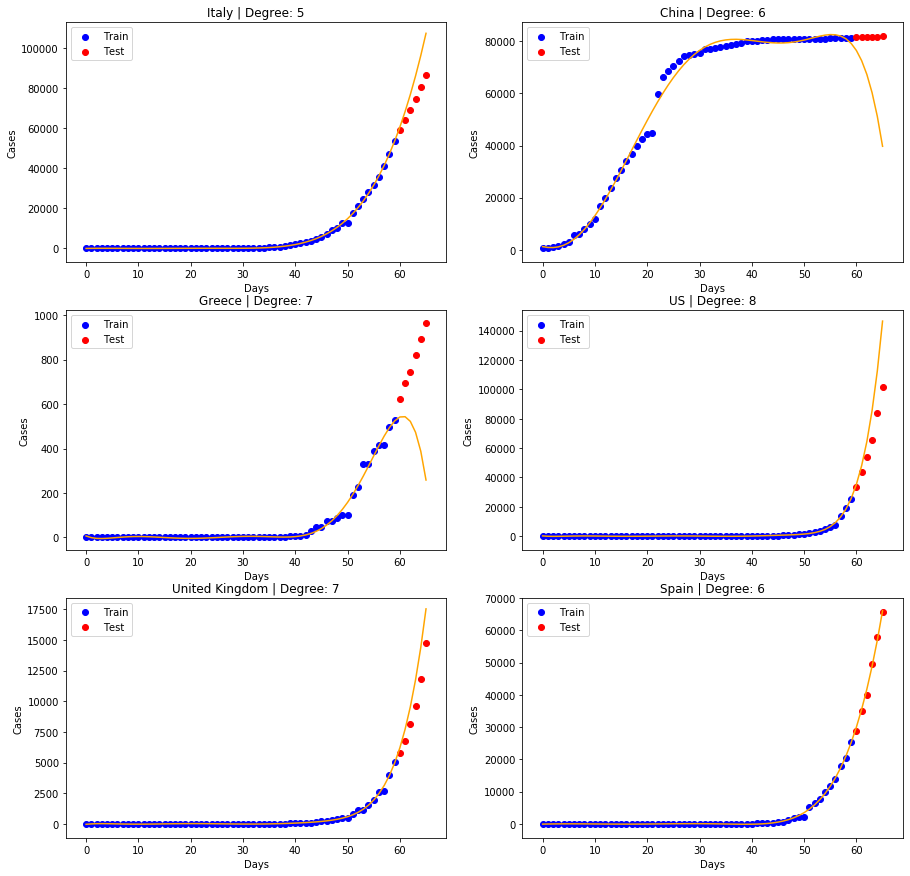

In [17]:
# Which countries will be plotted
example_countries = ["Italy", "China", "Greece", "US", "United Kingdom", "Spain"]

cols = 2
rows = np.ceil(len(example_countries) / cols)
fig = plt.figure(figsize=(15, 15))
plot_index = 1

for country in example_countries:
    # Get the dataset
    full_x = np.array(x_data[:, np.newaxis])
    full_y = np.array(confirmed_cases_df.loc[country][:, np.newaxis])
    
    # Create the features and predict using the best model of each country
    model, degree = country_models[country]
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(full_x)
    pred_Y = model.predict(x_poly)
    
    # Plot the true train, test points and the predicted line
    ax = fig.add_subplot(rows, cols, plot_index)
    plt.plot(full_x, pred_Y, color="orange")
    plt.scatter(full_x[:-test_days], full_y[:-test_days], color="blue", label="Train")
    plt.scatter(full_x[-test_days:], full_y[-test_days:], color="red", label="Test")
    
    plt.xlabel("Days")
    plt.ylabel("Cases")
    plt.title(f"{country} | Degree: {degree}")
    plt.legend()
    plot_index += 1

plt.show()

As we can see for some countries that are experiencing great increase of cases our model is doing a good job with acceptable forecasts on the test set.  
For some others like China our model predicts an increase which is not true. I believe this is happening due to the high degree polynomial chosen, that our models "spend" after the end of the training set.

### Distribution of Degrees

Following I calculate and visualize the distribution of degrees for all the best models of each country.  
Increasing the `bic_criterion` value we will have bigger tolerance of error choosing simpler models and vice versa.

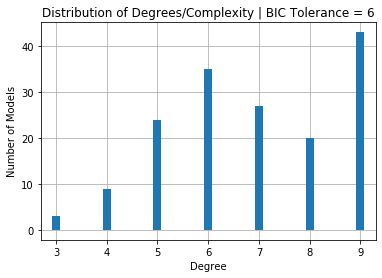

In [24]:
models_degrees = np.array(list(country_models.values()))[:, 1]

values, counts = np.unique(models_degrees, return_counts=True)
plt.vlines(values, 0, counts, color='C0', lw=8)
plt.xlabel("Degree")
plt.ylabel("Number of Models")
plt.title(f"Distribution of Degrees/Complexity | BIC Tolerance = {bic_criterion}")
plt.grid()
plt.show()

## ARIMA

[Autoregressive integrated moving average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) models are used for better understanding time series data or for predicting future values.  

We will undergo the following stages:
1. Stationarize the time series
2. Find the best parameters for our model (p,d,q)
3. Fit the model
4. Perform predictions

### Global Forecasting
I will perform the above  steps on the global statistics (like I did with polynomial fitting).

#### Stationarize the time series

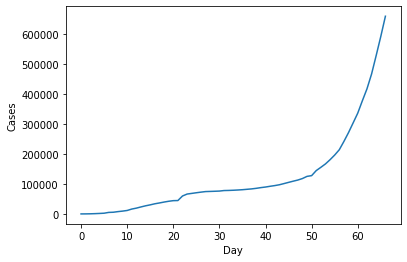

In [137]:
# First we plot the line of the global cases
plt.plot(np.arange(len(global_cases_df)), global_cases_df)
plt.xlabel("Day")
plt.ylabel("Cases")
plt.show()

As expected our series has no seasonality but is in a constant upward trend. 

In [138]:
# We will use a part of the data for training
testing_arima_days = 10
global_cases_df.index = pd.to_datetime(global_cases_df.index)
global_cases_df_train = global_cases_df[:-testing_arima_days]

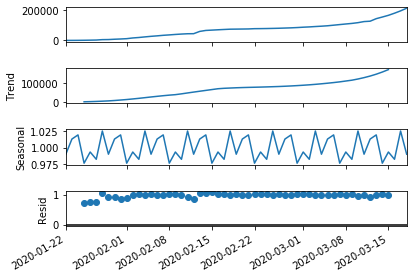

In [139]:
# Seasonal decompose to extract trend, seasonality and residues
result = seasonal_decompose(global_cases_df_train, model='multiplicative')
result.plot()
plt.gcf().autofmt_xdate()
plt.show()

Since we consider a multiplicative model (since we have an exponential increase as time increases) our model has the form of  
$$y(t) = Level * Trend * Seasonality * Noise$$
With seasonal and residuals being close to 1, we can see that our time series has **a trend, no seasonality and little to no noise.**  
  
Most of the forecasting models need our series to be stationarized (almost stationary) since this has the nice property of easily "predicting the future will be the same as the past".  
  
The test we will use for determining if our data is stationarized is the [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If we **fail to reject the null hypothesis**, we can say that the series **is non-stationary** [(ref)](https://www.kdnuggets.com/2020/01/predict-electricity-consumption-time-series-analysis.html).

In [140]:
# Perform dickey fuller test  
print("Results of dickey fuller test")
adft = adfuller(global_cases_df, autolag='BIC')
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 1.748586
p-value                         0.998241
No. of lags used                3.000000
Number of observations used    63.000000
critical value (1%)            -3.538695
critical value (5%)            -2.908645
critical value (10%)           -2.591897
dtype: float64


As expected we are not at all able to reject the null hypothesis with a p-value of 0.998.  
To get a stationarized series we must eliminate the trend.

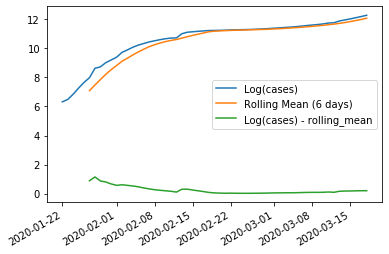

In [141]:
rolling_mean_window = 6

# Take the log of the values to stabilize their rate of increase
global_cases_df_log = np.log(global_cases_df_train)

# Calculate the rolling average (the window is define by rolling_mean_window)
moving_avg = global_cases_df_log.rolling(rolling_mean_window).mean()

# Subtract the rolling average from the log number of cases
global_cases_log_moving_avg_diff = global_cases_df_log - moving_avg
global_cases_log_moving_avg_diff.dropna(inplace=True)

plt.plot(global_cases_df_log, label="Log(cases)")
plt.plot(moving_avg, label=f"Rolling Mean ({rolling_mean_window} days)")
plt.plot(global_cases_log_moving_avg_diff, label="Log(cases) - rolling_mean")

plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [142]:
# We again do the ADF test
print("Results of dickey fuller test")
adft = adfuller(global_cases_log_moving_avg_diff, autolag='BIC')
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                -2.684845
p-value                         0.076698
No. of lags used                0.000000
Number of observations used    51.000000
critical value (1%)            -3.565624
critical value (5%)            -2.920142
critical value (10%)           -2.598015
dtype: float64


We get a p-value of 0.06 and due to some anomalies (big jump around 2/15) I will consider this enough and continue with finding the p, q values for the ARIMA model.  
One should note that if our data had seasonality we should probably also do differencing.

#### Define p, d, q

ARIMA has 3 values that must be carefully defined:
* **p**: Number of autoregressive terms
* **d**: Number of nonseasonal differences needed for stationarity
* **q**: Number of lagged forecast errors in the prediction equation
  
**In order to define p, q we will plot the Auto Correlation Function(ACF) and the Partially Auto Correlation Function(PACF).**

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


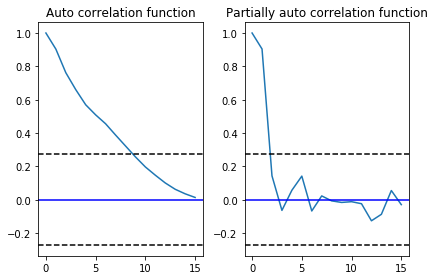

In [143]:
acf = acf(global_cases_log_moving_avg_diff, nlags=15)
pacf= pacf(global_cases_log_moving_avg_diff, nlags=15,method='ols')

# ACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(global_cases_log_moving_avg_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(global_cases_log_moving_avg_diff)),linestyle='--',color='black')
plt.title('Auto correlation function')
plt.tight_layout()

# PACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(global_cases_log_moving_avg_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(global_cases_log_moving_avg_diff)),linestyle='--',color='black')
plt.title('Partially auto correlation function')
plt.tight_layout()

We observe a continuous decrease of the ACF while PACF remains significant until value 3. This means that we have an **AR process** where p = 3, q = 0.

#### Fitting ARIMA model

Having determined the nature of our process (AR(3)) and its values  we will then proceed on fitting on our training data.

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


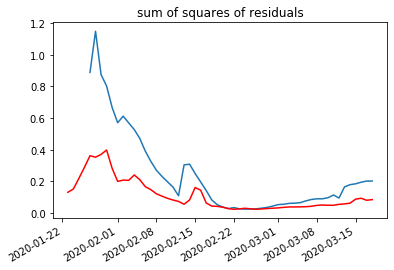

RSS : 2.421485


In [144]:
model = ARIMA(global_cases_df_log, order=(3,1,0))
fit_result = model.fit(disp = 0)

plt.plot(global_cases_log_moving_avg_diff)
plt.plot(fit_result.fittedvalues, color='red')
plt.title("sum of squares of residuals")

plt.gcf().autofmt_xdate()
plt.show()
print('RSS : %f' %sum((fit_result.fittedvalues-global_cases_log_moving_avg_diff).dropna()**2))

#### Forecasting with ARIMA

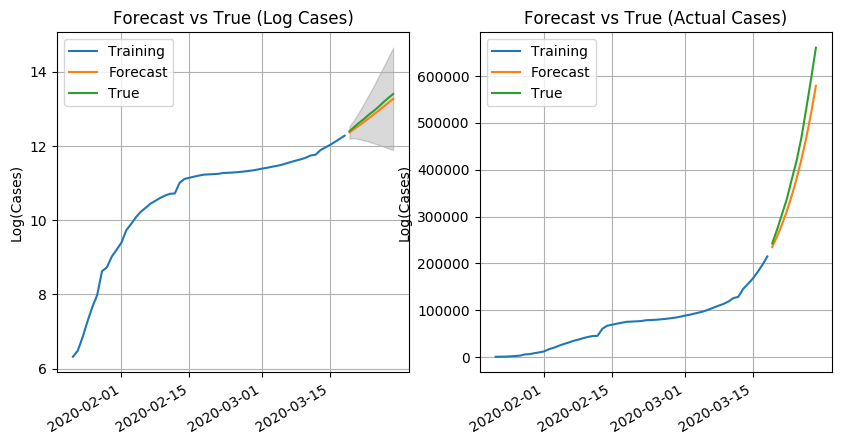

In [163]:
# We then forecast our last testing days
fc, se, conf = fit_result.forecast(testing_arima_days, alpha=0.05)

# Match the index of the correct dates so as to be on the correct day on the below plots
fc_series = pd.Series(fc, index=global_cases_df.index[-testing_arima_days:])
lower_series = pd.Series(conf[:, 0], index=global_cases_df.index[-testing_arima_days:])
upper_series = pd.Series(conf[:, 1], index=global_cases_df.index[-testing_arima_days:])

fig = plt.figure(figsize=(10,5), dpi=100)

# Log Cases Plot
ax = fig.add_subplot(1, 2, 1)
plt.plot(global_cases_df_log, label='Training')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.plot(np.log(global_cases_df[-testing_arima_days:]), label='True')

plt.title('Forecast vs True (Log Cases)')
plt.ylabel("Log(Cases)")
plt.legend()

plt.grid()
plt.gcf().autofmt_xdate()

# Actual Scale Cases
ax = fig.add_subplot(1, 2, 2)
plt.plot(np.exp(global_cases_df_log), label='Training')
plt.plot(np.exp(fc_series), label='Forecast')
plt.plot(global_cases_df[-testing_arima_days:], label='True')

plt.title('Forecast vs True (Actual Cases)')
plt.ylabel("Log(Cases)")
plt.legend()

plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

We can see that we are getting close to true results that with great confidence (the grey area is the 95% confidence band). Admittedly, the problem with the global cases is easy for he polynomial and the ARIMA fitting. I believe that the true power of ARIMA would be on more difficulties countries like China and Greece that polynomial fitting was failing.